In [6]:
using LinearAlgebra
using SparseArrays
using BenchmarkTools
using Random
using Distributions
using Plots

In [104]:
ct1 = 0
ct2 = 0
for _ in 1:10000
    foo = rand(Uniform(-10,10), 4, 4)
    l1, _ = eigen(foo)
    l1 = real.(l1)
    l1_min = minimum(l1)
    l1_max = maximum(l1)

    bar = (foo + foo')/2
    l2, _ = eigen(bar)
    l2_min = minimum(l2)
    l2_max = maximum(l2)

    ct1 += Int(l1_min < l2_min)
    ct2 += Int(l2_max < l1_max)
end
println("ct1 = ", ct1)
println("ct2 = ", ct2)

ct1 = 0
ct2 = 0


In [105]:
foo = rand(Uniform(-10,10), 4, 4)
bar = (foo + foo')/2
pac = (foo - foo')/2

γ = 0.1
λp, v = eigen(bar)
# N_neg = count(i->(real(i) < 0.0), λp)
λp[real.(λp) .< 0] .= γ  # .+ (rand(N_neg) .* γ/10)
# N_img = count(i->(imag(i) != 0.0), λp)
# λp[imag.(λp) .!= 0.0] .= real.(λp[imag.(λp) .!= 0.0]) #+ rand(N_img) 
zap = v * Diagonal(λp) * (v\1.0I)

4×4 Matrix{Float64}:
  0.210726   -0.0982325  0.113304    0.111711
 -0.0982325   7.25141    0.0570213  -3.6207
  0.113304    0.0570213  0.219455    0.0357768
  0.111711   -3.6207     0.0357768   1.96825

In [14]:
a = [1 -1 0 -2]
b = any(a .< -3) + any(a .> 1) + any(a .> 0.1)

1

In [12]:
10^floor(log10(0.055)) / 2

0.005000000000000001

In [3]:
x = range(0,1,2^7)

0.0:0.007874015748031496:1.0

In [4]:
train_wave = (a,b,c) -> a .* sin.(2*π*ceil(b) .* x .+ c)

#11 (generic function with 1 method)

In [14]:
norm(train_wave(0.6,7,3))

4.781962917924284

In [5]:
if (@isdefined a) && (@isdefined b) && (@isdefined c)
    println("a and b are defined")
end

In [15]:
train_wave = (a,b,c) -> exp.(-a * cos.(π .* x .+ b).^2) .- c

#13 (generic function with 1 method)

In [45]:
train_wave3 = (a,b,c) -> exp.(-a * cos.(π .* x).^2 .+ b .* sin.(4*π .* x .+ π/3).^2 .- c .* cos.(3*π .* x).^2) 

#19 (generic function with 1 method)

In [74]:
norm(train_wave3(1,0.5,1))

7.1809556661202025

In [106]:
eigen(zap)

Eigen{Float64, Float64, Matrix{Float64}, Vector{Float64}}
values:
4-element Vector{Float64}:
 0.09999999999999949
 0.09999999999999963
 0.35584024650442625
 9.093994817808978
vectors:
4×4 Matrix{Float64}:
  0.758565   0.0937271  -0.651413  -0.0155071
 -0.11616    0.391881   -0.156486   0.891311
 -0.586409  -0.504641   -0.682957   0.00370225
 -0.259249   0.763532   -0.291107  -0.453113

In [107]:
eigen(bar)

Eigen{Float64, Float64, Matrix{Float64}, Vector{Float64}}
values:
4-element Vector{Float64}:
 -15.291019624856911
  -7.09950814662783
   0.35584024650442636
   9.093994817808985
vectors:
4×4 Matrix{Float64}:
  0.703379   0.28404   0.651413   0.0155071
 -0.260996   0.336093  0.156486  -0.891311
 -0.380669  -0.623416  0.682957  -0.00370225
 -0.540583   0.646309  0.291107   0.453113

In [10]:
s

4-element Vector{ComplexF64}:
               0.1 + 0.0im
               0.1 + 0.0im
 12.33193892302421 - 3.479711733044939im
 12.33193892302421 + 3.479711733044939im

In [15]:
v * diagm(s) * v^(-1)

4×4 Matrix{ComplexF64}:
  7.39597+4.0359e-16im   6.96738+2.62968e-15im  …   5.47594-7.06443e-16im
 -1.13444+2.30578e-16im  3.05888-1.18363e-15im     -3.99011+1.22111e-15im
  2.31802+4.66593e-16im  6.21741+3.06297e-16im     -1.36905+9.12678e-16im
  6.30664+1.25411e-16im  4.80703+2.06405e-15im      5.77726-8.21851e-16im

In [10]:
M = [0 0 0 -9;
    1 0 0 0;
    0 1 0 10;
    0 0 1 0]
s, v = eigen(M)

N = [0 0 0; 1 0 5; 0 1 0]
s, v = eigen(N)

f = (x) -> x.^4 -10 .* x.^2 .+ 9
for si in s
    val = f(si)
    println("f($si) = $val")
end

f(-2.23606797749979) = -16.000000000000004
f(0.0) = 9.0
f(2.23606797749979) = -16.000000000000004


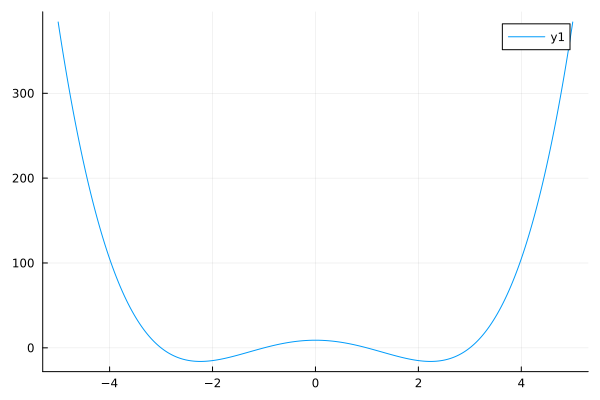

In [13]:
plot(-5:0.01:5, f(-5:0.01:5))

In [22]:
using JuMP
using Ipopt
using Pipe

i = 2
model = Model(Ipopt.Optimizer; add_bridges=false)
@variable(model, x[1:5])

@pipe x |> [JuMP.delete(model, x), JuMP.unregister(model, :x)]
@show JuMP.is_valid(model, x)

MethodError: MethodError: objects of type Vector{Nothing} are not callable
Use square brackets [] for indexing an Array.

In [2]:
struct elemat{T} <: AbstractVector{T}
    n::Int
    i::Int

    function elemat(n::Int, i::Int)
        @boundscheck n >= i || throw(ArgumentError("$i is larger than the size $n"))
        e = spzeros(n,1)
        e[i] = 1
        return e
    end
end

"""
    elemat(n,i,j)
"""

struct Elemat{T} <: AbstractMatrix{T}
    m :: Int
    n :: Int
    i :: Int
    j :: Int
    
    function Elemat(m::Integer, n::Integer, i::Integer, j::Integer)
        return elemat(m,i) * elemat(n,j)'
    end
end

Elemat(m::Integer, i::Integer, j::Integer) = Elemat(m, m, i, j)

Elemat

In [3]:
# Kronecker delta
function delta(i::Int, j::Int)
    return Int(i == j)
end

"""
    commat(n,i,j)
"""

struct commat{T} <: AbstractMatrix{T}
    m::Int
    n::Int

    function commat(m::Integer, n::Integer)
        v = [m * (j-1) + i for i in 1:m, j in 1:n]'[:]
        # apply this permutation to the rows (i.e. to each column) of identity matrix
        K = [[delta(i, j) for j in 1:(m*n)] for i in 1:(m*n)]
        tmp = [K[i] for i in v]
        return sparse(reduce(vcat, tmp'))
    end
end

commat(m::Integer) = commat(m, m)


"""
    nommat(n,i,j)
"""

struct nommat{T} <: AbstractMatrix{T}
    m::Int
    n::Int

    function nommat(m::Integer, n::Integer)
        mn = Int(m * n)
        return 0.5 * (sparse(1.0I, mn, mn) + commat(m, n))
    end
end

nommat(m::Integer) = nommat(m, m)

nommat

In [4]:
function vech(A::AbstractMatrix{T}) where {T}
    m = LinearAlgebra.checksquare(A)
    v = Vector{T}(undef, Int(m * (m + 1) /2))
    k = 0
    for j = 1:m, i = j:m
        @inbounds v[k+=1] = A[i, j]
    end
    return v
end

vech (generic function with 1 method)

In [5]:
struct unit_DL{T} <: AbstractVector{T}
    n::Int
    i::Int
    j::Int

    function unit_DL(n::Integer, i::Integer, j::Integer)
        @boundscheck i >= j || throw(ArgumentError("Does not satisfy i >= j"))
        u = spzeros(Int(0.5 * n * (n+1)), 1)
        u[Int( (j-1)*n + i - 0.5*j*(j-1) )] = 1.0
        return u
    end
end

In [6]:
struct elimat{T} <: AbstractMatrix{T}
    m::Int
    
    function elimat(m::Integer)
        T = tril(ones(m, m)) # Lower triangle of 1's
        f = findall(x -> x == 1, T[:]) # Get linear indexes of 1's
        k = m * (m + 1) / 2 # Row size of L
        m2 = m * m # Colunm size of L
        x = f + m2 * (0:k-1) # Linear indexes of the 1's within L'

        row = [mod(a, m2) != 0 ? mod(a, m2) : m2 for a in x]
        col = [mod(a, m2) != 0 ? div(a, m2) + 1 : div(a, m2) for a in x]
        L = sparse(row, col, ones(length(x)), m2, k)
        L = L' # Now transpose to actual L
        return L
    end
end

In [11]:
N = 3
Δx = 0.5
S = Int(N * (N + 1) / 2)
Fval = repeat([1.0, 1.0, -1.0, -1.0], outer=N - 2)

4-element Vector{Float64}:
  1.0
  1.0
 -1.0
 -1.0

In [12]:
row_i = repeat(2:(N-1), inner=4)

4-element Vector{Int64}:
 2
 2
 2
 2

In [14]:
N = 4
seq = Int.([2 + (N + 1) * (x - 1) - x * (x - 1) / 2 for x in 1:(N-1)])

3-element Vector{Int64}:
 2
 6
 9

In [ ]:
col_i = vcat(seq[1], repeat(seq[2:end-1], inner=2), seq[end])

In [ ]:
F = sparse(row_i, col_i, Fval, N, S) / 2 / Δx

In [54]:
N = 4
S = N*(N+1)/2
dx = 1/6

ii = repeat(2:(N-1), inner=4)
m = 2:N-1
mi = Int.([N*(N+1)/2 - (N-m)*(N-m+1)/2 - (N-m) for m in 2:N-1])               # this is where the xi^2 term is
mm = Int.([N*(N+1)/2 - (N-m).*(N-m+1)/2 - (N-m) - (N-(m-2)) for m in 2:N-1])  # this is where the x_{i-1}^2 term is
mp = Int.([N*(N+1)/2 - (N-m).*(N-m+1)/2 - (N-m) + (N-(m-1)) for m in 2:N-1])  # this is where the x_{i+1}^2 term is
jp = mi .+ 1  # this is the index of the x_{i+1}*x_i term
jm = mm .+ 1  # this is the index of the x_{i-1}*x_i term
jj = reshape([mp'; mm'; jp'; jm'],4*N-8);
vv = reshape([-ones(1,N-2); ones(1,N-2); -ones(1,N-2); ones(1,N-2)],4*N-8)/(6*dx);
F = sparse(ii,jj,vv,N,N*(N+1)/2)
# Boundary conditions
F[1,2] = -1/6/dx
F[1,N+1] = -1/6/dx
F[N,end-1] = 1/6/dx
F[N,end-2] = 1/6/dx
F

4×10 SparseMatrixCSC{Float64, Int64} with 12 stored entries:
  ⋅   -1.0   ⋅    ⋅   -1.0    ⋅    ⋅     ⋅     ⋅     ⋅ 
 1.0   1.0   ⋅    ⋅     ⋅   -1.0   ⋅   -1.0    ⋅     ⋅ 
  ⋅     ⋅    ⋅    ⋅    1.0   1.0   ⋅     ⋅   -1.0  -1.0
  ⋅     ⋅    ⋅    ⋅     ⋅     ⋅    ⋅    1.0   1.0    ⋅ 

In [64]:
a = range(0.8,1.2,10)

0.8:0.044444444444444446:1.2

In [67]:
zeros(1,1) .* rand(5,5)

5×5 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0

In [78]:
a  = zeros(1,1)
a[1] == 0
a = size(a)==(1,1) && a[1]==0 ? 0 : 1

0

In [86]:
typeof(NaN) == Float64

true

In [3]:
a = 1 
b = 2
c = 3 
n = 10
@info """

Constraint         = Non-Constrained
order              = $(n)
termination_status = $(a)
primal_status      = $(b)
objective_value    = $(c)
"""

┌ Info: 
│ Constraint        = Non-Constrained
│ order              = 10
│ termination_status = 1
│ primal_status      = 2
│ objective_value    = 3
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\scribble.ipynb:5


In [21]:
function generateEPmatrix(N, Δx, μ::Float64)
    # Create A matrix
    A = diagm(0 => (-2) * ones(N), 1 => ones(N - 1), -1 => ones(N - 1)) * μ / Δx^2
    A[1, N] = μ / Δx^2
    A[N, 1] = μ / Δx^2

    # Create F matrix
    S = Int(N * (N + 1) / 2)
    if N >= 3
        ii = repeat(2:(N-1), inner=4)
        m = 2:N-1
        mi = Int.([N*(N+1)/2 - (N-m)*(N-m+1)/2 - (N-m) for m in 2:N-1])               # this is where the xi^2 term is
        mm = Int.([N*(N+1)/2 - (N-m).*(N-m+1)/2 - (N-m) - (N-(m-2)) for m in 2:N-1])  # this is where the x_{i-1}^2 term is
        mp = Int.([N*(N+1)/2 - (N-m).*(N-m+1)/2 - (N-m) + (N-(m-1)) for m in 2:N-1])  # this is where the x_{i+1}^2 term is
        jp = mi .+ 1  # this is the index of the x_{i+1}*x_i term
        jm = mm .+ 1  # this is the index of the x_{i-1}*x_i term
        jj = reshape([mp'; mm'; jp'; jm'],4*N-8);
        vv = reshape([-ones(1,N-2); ones(1,N-2); -ones(1,N-2); ones(1,N-2)],4*N-8)/(6*Δx);
        F = sparse(ii,jj,vv,N,S)

        # Boundary conditions
        F[1,2] = -1/6/Δx
        F[1,N+1] = -1/6/Δx
        F[1,N] = 1/6/Δx
        F[1,end] = 1/6/Δx
        F[N,end-1] = 1/6/Δx
        F[N,end-2] = 1/6/Δx
        F[N,1] = -1/6/Δx
        F[N,N] = -1/6/Δx
    else
        F = zeros(N, S)
    end

    return A, F
end

generateEPmatrix (generic function with 1 method)

In [24]:
A, F = generateEPmatrix(4, 1/6, 1.0)

([-72.0 36.0 0.0 36.0; 36.0 -72.0 36.0 0.0; 0.0 36.0 -72.0 36.0; 36.0 0.0 36.0 -72.0], sparse([2, 4, 1, 2, 1, 4, 1, 3, 2, 3, 2, 4, 3, 4, 1, 3], [1, 1, 2, 2, 4, 4, 5, 5, 6, 6, 8, 8, 9, 9, 10, 10], [1.0, -1.0, -1.0, 1.0, 1.0, -1.0, -1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, 1.0, 1.0, -1.0], 4, 10))

In [25]:
F

4×10 SparseMatrixCSC{Float64, Int64} with 16 stored entries:
   ⋅   -1.0   ⋅    1.0  -1.0    ⋅    ⋅     ⋅     ⋅    1.0
  1.0   1.0   ⋅     ⋅     ⋅   -1.0   ⋅   -1.0    ⋅     ⋅ 
   ⋅     ⋅    ⋅     ⋅    1.0   1.0   ⋅     ⋅   -1.0  -1.0
 -1.0    ⋅    ⋅   -1.0    ⋅     ⋅    ⋅    1.0   1.0    ⋅ 

In [20]:
A

5×5 Matrix{Float64}:
 -72.0   36.0    0.0    0.0   36.0
  36.0  -72.0   36.0    0.0    0.0
   0.0   36.0  -72.0   36.0    0.0
   0.0    0.0   36.0  -72.0   36.0
  36.0    0.0    0.0   36.0  -72.0